In [1]:
import hifi_gan
import torch

In [2]:
import g2p_en

In [3]:
g2p = g2p_en.G2p()

In [4]:
import re

def to_arpabet(g2p, text):
    """Convert a sentence in english to arpabet."""
    g2p_out = g2p(text)
    current = 0
    current_tokens = []
    current_token_is_punc = False
    output = []
    while True:
        if current >= len(g2p_out) or g2p_out[current] == " ":
            if current_token_is_punc:
                output.append("".join(current_tokens))
            else:
                output.append("{%s}" % (" ".join(current_tokens)))
            current_tokens = []
            if current >= len(g2p_out):
                break
        else:
            if len(current_tokens) == 0:
                current_token_is_punc = (
                    re.match(r"[,'\-!\.?]+", g2p_out[current]) is not None
                )
            current_tokens.append(g2p_out[current])
        current += 1

    return " ".join(output)

In [5]:
import os
import json
import hifi_gan
from hifi_gan.env import AttrDict
from hifi_gan.inference_e2e import load_checkpoint
from hifi_gan.meldataset import MAX_WAV_VALUE
from hifi_gan.models import Generator

def load_hifi_gan(path, device="cpu"):
    dev = torch.device(device)
    with open(os.path.join(path, "config.json"), "r") as f:
        config = AttrDict(json.load(f))
    generator = Generator(config).to(dev)
    for file in os.listdir(path):
        if file.startswith("g_"):
            gen_filename = file
    state_dict_g = load_checkpoint(os.path.join(path, gen_filename), dev)
    print(state_dict_g.keys())
    generator.load_state_dict(state_dict_g['generator'])
    generator.eval()
    generator.remove_weight_norm()
    return generator

In [6]:
gen = load_hifi_gan("/home/ubuntu/UNIVERSAL_V1/", device="cuda")

Loading '/home/ubuntu/UNIVERSAL_V1/g_02500000'
Complete.
dict_keys(['generator'])
Removing weight norm...


In [7]:
model = torch.hub.load(
    "nvidia/DeepLearningExamples:torchhub", 
    "nvidia_tacotron2", 
    pretrained=False,
)

Using cache found in /home/ubuntu/.cache/torch/hub/nvidia_DeepLearningExamples_torchhub


In [8]:
print("michael rosen")
!ls output_michaelrosen2/
print("trebek")
!ls output_trebek/
print("lj")
!ls output

michael rosen
checkpoint_Tacotron2_360.pt  checkpoint_Tacotron2_600.pt
checkpoint_Tacotron2_380.pt  checkpoint_Tacotron2_620.pt
checkpoint_Tacotron2_400.pt  checkpoint_Tacotron2_640.pt
checkpoint_Tacotron2_420.pt  checkpoint_Tacotron2_660.pt
checkpoint_Tacotron2_440.pt  checkpoint_Tacotron2_680.pt
checkpoint_Tacotron2_460.pt  checkpoint_Tacotron2_700.pt
checkpoint_Tacotron2_480.pt  checkpoint_Tacotron2_720.pt
checkpoint_Tacotron2_500.pt  checkpoint_Tacotron2_740.pt
checkpoint_Tacotron2_520.pt  checkpoint_Tacotron2_760.pt
checkpoint_Tacotron2_540.pt  checkpoint_Tacotron2_780.pt
checkpoint_Tacotron2_560.pt  checkpoint_Tacotron2_last.pt
checkpoint_Tacotron2_580.pt  nvlog.json
trebek
checkpoint_Tacotron2_350.pt  checkpoint_Tacotron2_500.pt   nvlog.json
checkpoint_Tacotron2_400.pt  checkpoint_Tacotron2_550.pt
checkpoint_Tacotron2_450.pt  checkpoint_Tacotron2_last.pt
lj
checkpoint_Tacotron2_0.pt    checkpoint_Tacotron2_450.pt
checkpoint_Tacotron2_100.pt  checkpoint_Tacotron2_50.pt
checkpoint

In [10]:
checkpoint = torch.load("output_michaelrosen2/checkpoint_Tacotron2_last.pt")

In [11]:
model.load_state_dict(checkpoint["state_dict"])

<All keys matched successfully>

In [20]:
arpabet = to_arpabet(
    g2p,
    # "Never gonna give you up. Never gonna let you down. Never gonna run around and desert me."
    # "What the fuck did you just fucking say about me, you little bitch?"
    # "Loads to eat, I had cod and chips, the cod was huge and there were hundreds of chips."
    "I'm infinite. You heard of hell? Well I was sent from it."
    #"I'd just like to interject for a moment. What you're referring to as Linux, is in fact, Windows Subsystem for Linux, or as I've recently taken to calling it, W S L."
)
print(arpabet)

{AY1 M} {IH1 N F AH0 N AH0 T} . {Y UW1} {HH ER1 D} {AH1 V} {HH EH1 L} ? {W EH1 L} {AY1} {W AA1 Z} {S EH1 N T} {F R AH1 M} {IH1 T} .


In [21]:
from tacotron2.text import text_to_sequence
import numpy as np
model = model.cuda()

In [22]:
seq = np.array(text_to_sequence(arpabet, ["english_cleaners"]))[None, :]
seq = torch.from_numpy(seq).to(device="cuda", dtype=torch.int64)

In [23]:
model.eval()
_, mel, _, alignments = model.infer(seq)

In [24]:
MAX_WAV_VALUE = 30000.0
tensor_cls = torch.FloatTensor if not torch.cuda.is_available() else torch.cuda.FloatTensor
y_g_hat = gen(tensor_cls(mel).to(device="cuda"))
audio = y_g_hat.squeeze()
audio = audio * MAX_WAV_VALUE
audio = audio.unsqueeze(0)

In [25]:
from IPython.display import Audio

In [26]:
Audio(audio.data.cpu().numpy(), rate=22050)

(80, 352)
(53, 352)


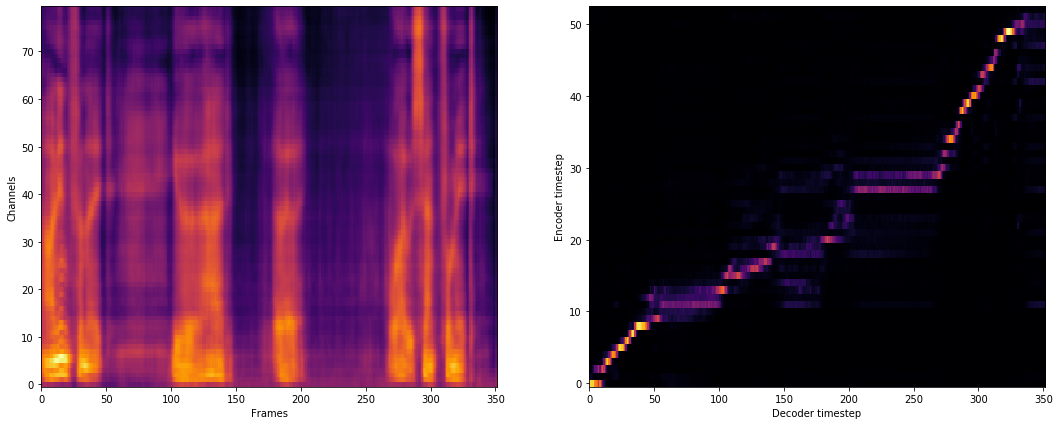

In [27]:
import matplotlib.pylab as pylab

alignment_graph_width = 1800
alignment_graph_height = 720
graph_scale = 1

def plot_data(data, info=None):
    %matplotlib inline
    fig, axes = pylab.subplots(1, len(data), figsize=(int(alignment_graph_width*graph_scale/100), int(alignment_graph_height * graph_scale / 100)))
    for i in range(len(data)):
        print(data[i].shape)
        axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                       interpolation='none', cmap='inferno')
    axes[0].set(xlabel="Frames", ylabel="Channels")
    axes[1].set(xlabel="Decoder timestep", ylabel="Encoder timestep")
    fig.canvas.draw()
    pylab.show()

plot_data([
  mel[0].data.cpu().numpy(),
  alignments[0].data.cpu().numpy().T,
])

# Parse nvlog

In [46]:
!tail -n100 output_michaelrosen2/nvlog.json

DLLL {"timestamp": "1613260158.487929", "datetime": "2021-02-13 23:49:18.487929", "elapsedtime": "24111.014423", "type": "LOG", "step": [790, 1], "data": {"glob_iter/iters_per_epoch": "5708/13"}}
DLLL {"timestamp": "1613260159.993744", "datetime": "2021-02-13 23:49:19.993744", "elapsedtime": "24112.520238", "type": "LOG", "step": [790, 1], "data": {"train_loss": 0.3499102294445038}}
DLLL {"timestamp": "1613260161.941808", "datetime": "2021-02-13 23:49:21.941808", "elapsedtime": "24114.468302", "type": "LOG", "step": [790, 1], "data": {"train_items_per_sec": 4538.938052832199}}
DLLL {"timestamp": "1613260161.941942", "datetime": "2021-02-13 23:49:21.941942", "elapsedtime": "24114.468436", "type": "LOG", "step": [790, 1], "data": {"train_iter_time": 3.453891597004258}}
DLLL {"timestamp": "1613260161.951703", "datetime": "2021-02-13 23:49:21.951703", "elapsedtime": "24114.478197", "type": "LOG", "step": [790, 2], "data": {"glob_iter/iters_per_epoch": "5709/13"}}
DLLL {"timestamp": "161326

In [47]:
import json
training_loss = []
val_loss = []
with open("output_michaelrosen2/nvlog.json", "r") as f:
    for line in f.readlines():
        data = json.loads(line[5:])
        if "data" in data and "train_loss" in data["data"]:
            training_loss.append(data)
        if "data"in data and "val_loss" in data["data"]:
            val_loss.append(data)

In [34]:
len(training_loss)

6171

In [35]:
%matplotlib inline

In [38]:
steps = [t["step"][0] for t in training_loss]
loss = [t["data"]["train_loss"] for t in training_loss]

In [39]:
import matplotlib.pyplot as plt

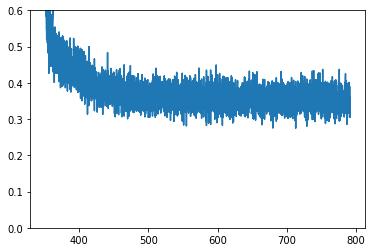

In [45]:
axis = plt.gca()
axis.set_ylim([0, 0.6])
plt.plot(steps, loss)

In [50]:
steps = [t["step"][0] for t in val_loss]
losses = [t["data"]["val_loss"] for t in val_loss]

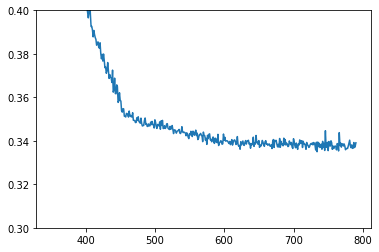

In [53]:
axis = plt.gca()
axis.set_ylim([0.3, 0.4])
plt.plot(steps, losses)